<a href="https://colab.research.google.com/github/AliAkbarBadri/mountain-car-v0/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet

In [ ]:
import matplotlib.animation
from IPython.display import HTML
from IPython.display import display as ipy_disp
import tensorflow as tf
import keras
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gym
import random

In [ ]:
def get_screen():
  global display
  try:
    display.stop()
  except:
    pass
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()

get_screen()

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [ ]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
import numpy as np
import gym
import collections
import random
import cv2
import keras
from keras.models import Model
from keras import layers
from keras import backend as K
from keras import optimizers
import pickle


#Set channel format for inputs
keras.backend.set_image_data_format('channels_first')


class CarAgent:
    def __init__(self, env):
        self.env = env
        self.num_actions = 3
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.decay_factor = (self.epsilon - self.epsilon_min) / 25000 # 2500
        self.discount_factor = 0.99                   
        self.memory = collections.deque(maxlen=200000) 
        self.learning_rate = 0.001                  
        self.image_width = 150                         
        self.image_height = 100                       
        self.stack_depth = 4                           
        self.model = self.create_CNN_model()           
        self.target_model = self.create_CNN_model()    
        self.update_target_weights()                   

    def create_CNN_model(self):

        input_shape = (self.stack_depth, self.image_height, self.image_width)
        actions_input = layers.Input((self.num_actions,), name = 'action_mask')

        frames_input = layers.Input(input_shape)
        conv_1 = layers.Conv2D(32, (8,8), strides=4, padding ='same', activation='relu', kernel_initializer='glorot_uniform',bias_initializer='zeros')(frames_input)
        conv_2 = layers.Conv2D(64, (4,4), strides=2, padding='same', activation='relu',kernel_initializer='glorot_uniform',bias_initializer='zeros')(conv_1)
        conv_3 = layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu',kernel_initializer='glorot_uniform',bias_initializer='zeros')(conv_2)
        flatten_1 = layers.Flatten()(conv_3)
        dense_1 = layers.Dense(512, activation='relu', kernel_initializer='glorot_uniform',bias_initializer='zeros')(flatten_1)
        output = layers.Dense(self.num_actions, activation='linear', kernel_initializer='glorot_uniform',bias_initializer='zeros')(dense_1)
        masked_output = layers.Multiply()([output, actions_input])

        model = Model([frames_input, actions_input], [masked_output])
        optimizer = optimizers.Adam(lr = self.learning_rate)
        model.compile(optimizer,loss=keras.losses.huber)
        return model

    def update_target_weights(self):
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])

    def process_image(self, image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (self.image_width, self.image_height))
        return image

    def greedy_action(self, current_state):
        current_state = np.float32(np.true_divide(current_state,255))
        action_mask = np.ones((1, self.num_actions))
        q_values = self.model.predict([current_state, action_mask])[0]
        greedy_action = np.argmax(q_values)

        return greedy_action

    def calculate_targets(self, batch_size):
        current_states = []
        rewards = []
        actions = []
        next_states = []
        dones = []
        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, next_state, done = sample
            current_states.append(state)
            rewards.append(reward)
            actions.append(action)
            next_states.append(next_state)
            dones.append(done)

        current_states = np.array(current_states)
        current_states = np.float32(np.true_divide(current_states,255))
        next_states = np.array(next_states)
        next_states = np.float32(np.true_divide(next_states,255))
        action_mask = np.ones((1,self.num_actions))
        action_mask = np.repeat(action_mask, batch_size, axis=0)
        next_Q_values = self.target_model.predict([next_states, action_mask])
        next_Q_values[dones] = 0
        targets = rewards + self.discount_factor * np.max(next_Q_values, axis=1)
        action_mask_current = self.get_one_hot(actions)

        return current_states, action_mask_current, targets

    def get_one_hot(self,actions):
        actions = np.array(actions)
        one_hots = np.zeros((len(actions), self.num_actions))
        one_hots[:, 0][np.where(actions == 0)] = 1
        one_hots[:,1][np.where(actions == 1)] = 1
        one_hots[:, 2][np.where(actions == 2)] = 1
        return one_hots

    def train_from_experience(self, states, action_mask, targets ):
        labels = action_mask * targets[:, None]
        loss = self.model.train_on_batch([states, action_mask], labels)

    def save_model(self,name):
        self.model.save(name)

env = gym.make('MountainCar-v0')
agent = CarAgent(env)
stack_depth = 4
seq_memory = collections.deque(maxlen=stack_depth)
done = False
training = False
batch_size = 32
update_threshold = 5
save_threshold = 200
trials = 10000
trial_len = 200
collect_experience = 5000
frame_skip = 4
all_rewards = []

for episode in range(trials+1):
    seq_memory.clear()
    initial_state = env.reset()
    current_image = env.render(mode = 'rgb_array')
    frame = agent.process_image(current_image)
    frame = frame.reshape(1, frame.shape[0], frame.shape[1])
    current_state = np.repeat(frame, stack_depth, axis=0)
    seq_memory.extend(current_state)
    episode_reward = 0
    for step in range(trial_len):
        if step % frame_skip == 0:
            if training:
                agent.epsilon = agent.epsilon - agent.decay_factor
                agent.epsilon = max(agent.epsilon_min, agent.epsilon)
            if np.random.rand() <= agent.epsilon:
                action = env.action_space.sample()
            else:
                action = agent.greedy_action(current_state.reshape(1, current_state.shape[0]\
                                   , current_state.shape[1], current_state.shape[2]))
        next_pos, reward, done, _ = env.step(action)
        next_frame = env.render(mode='rgb_array')
        next_frame = agent.process_image(next_frame)
        seq_memory.append(next_frame)
        next_state = np.asarray(seq_memory)
        agent.memory.append([current_state, action, reward, next_state, done])
        current_state = next_state
        if len(agent.memory) == collect_experience:
            training = True
            print('Start training')
        if training:
            states, action_mask, targets = agent.calculate_targets(batch_size)
            agent.train_from_experience(states,action_mask, targets)
        if done:
            break
    all_rewards.append([episode, step+1])
    if episode % 100 == 0:
      print("Iteration: {} Score: -{}".format(episode, step+1))
    if training and (episode % update_threshold) == 0:
        agent.update_target_weights()
    if training and (episode%save_threshold) == 0:
        print('Data saved at epsisode:', episode)
        agent.save_model('./original_cnn{}.h5'.format(episode))
        pickle.dump(all_rewards, open('./rewards{}.dump'.format(episode), 'wb'))


env.close()

Iteration: 0 Score: -200.0
Iteration: 100 Score: -200.0
Iteration: 200 Score: -200.0
Iteration: 300 Score: -200.0
Iteration: 400 Score: -200.0
Iteration: 500 Score: -200.0
Iteration: 600 Score: -200.0
Iteration: 700 Score: -200.0
Iteration: 800 Score: -200.0
Iteration: 900 Score: -200.0
Iteration: 1000 Score: -200.0
Iteration: 1100 Score: -200.0
Iteration: 1200 Score: -200.0
Iteration: 1300 Score: -200.0
Iteration: 1400 Score: -200.0
Iteration: 1500 Score: -200.0
Iteration: 1600 Score: -200.0
Iteration: 1700 Score: -200.0
Iteration: 1800 Score: -200.0
Iteration: 1900 Score: -200.0
Iteration: 2000 Score: -200.0
Iteration: 2100 Score: -200.0
Iteration: 2200 Score: -200.0
Iteration: 2300 Score: -200.0
Iteration: 2400 Score: -200.0
Iteration: 2500 Score: -200.0
Iteration: 2600 Score: -200.0
Iteration: 2700 Score: -200.0
Iteration: 2800 Score: -200.0
Iteration: 2900 Score: -200.0
Iteration: 3000 Score: -200.0
Iteration: 3100 Score: -200.0
Iteration: 3200 Score: -200.0
Iteration: 3300 Score:

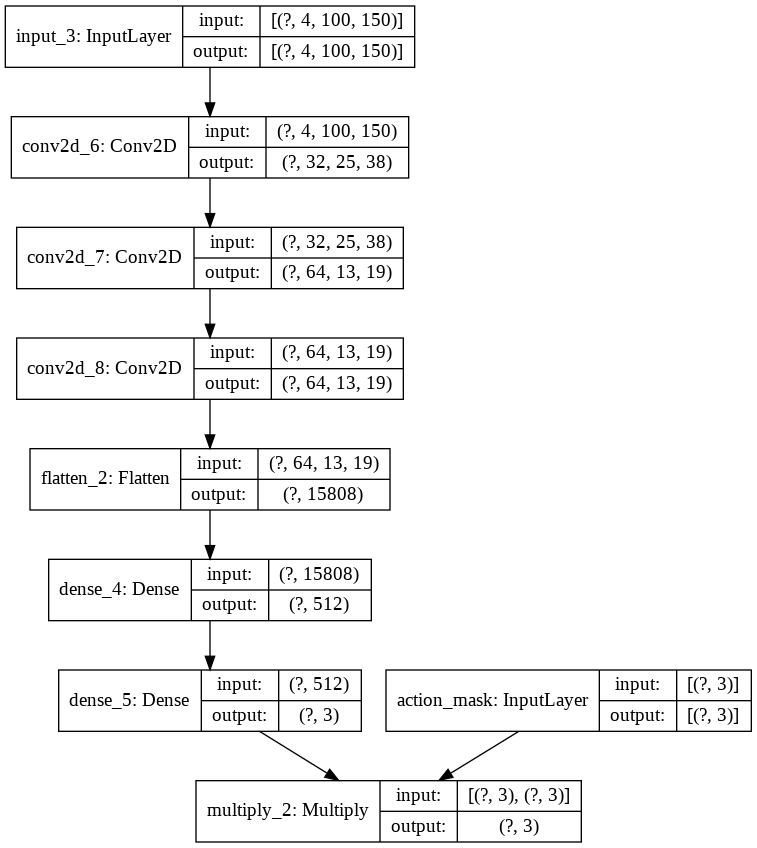

In [ ]:
keras.utils.plot_model(agent.model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
print("mean reward: ",np.mean(all_rewards),", best reward:",np.min(all_rewards),", first win episode:",np.argmin(all_rewards))

mean reward:  162.6121 , best reward: 83.0 , first win episode: 4345


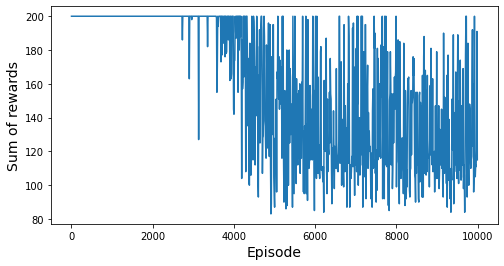

In [ ]:
x_range = range(0, 10000)
plt.figure(figsize=(8, 4))
plt.plot(x_range[1::10],all_rewards[1::10])
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()